In [1]:
import gym
import tensorflow as tf 
from tensorflow import optimizers, keras
from tensorflow.keras import layers
import numpy as np

In [2]:
env_name = "MountainCarContinuous-v0"
env = gym.make(env_name)
num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

In [3]:
num_states, num_actions, upper_bound, lower_bound

(2, 1, 1.0, -1.0)

In [4]:
class Noise : 
    def __init__(self, mean, std, theta=0.15, dt=1e-2, x_initial=None) :
        self.theta = theta
        self.mean = mean
        self.std = std
        self.dt = dt 
        self.x_initial = x_initial
        self.reset()
        
    def __call__(self) : 
        x = (
            self.x_prev 
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x
    
    def reset(self) :
        self.x_prev = np.zeros_like(self.mean) if self.x_initial is None else self.x_initial

In [5]:
class Buffer :
    def __init__(self, buffer_cap=1e5, batch_size=64) :
        self.buffer_cap = buffer_cap
        self.batch_size = batch_size
        self.buffer_count = 0
        self.states = np.zeros((self.buffer_cap, num_states))
        self.actions = np.zeros((self.buffer_cap, num_actions))
        self.rewards = np.zeros((self.buffer_cap, 1))
        self.next_states = np.zeros((self.buffer_cap, num_states))
        
    def record(self, observation) :
        index = self.buffer_count % self.buffer_cap
        self.states[index] = observation[0]
        self.actions[index] = observation[1]
        self.rewards[index] = observation[2]
        self.next_states[index] = observation[3]
        self.buffer_count += 1
        
    @tf.function
    def update(self, state_batch, action_batch, reward_batch, next_state_batch) :
        with tf.GradientTape() as tape :
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions], training=True)
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(zip(critic_grad, critic_model.trainable_variables))
        
        with tf.GradientTape() as tape :
            actions = actor_model(next_state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            actor_loss = -tf.math.reduce_mean(critic_value)
        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(zip(actor_grad, actor_model.trainable_variables))
    
    def learn(self) :
        record_range = min(self.buffer_count, self.buffer_cap)
        batch = np.random.choice(record_range, self.batch_size)
        
        state_batch = tf.convert_to_tensor(self.states[batch])
        action_batch = tf.convert_to_tensor(self.actions[batch])
        reward_batch = tf.convert_to_tensor(self.rewards[batch], dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_states[batch])
        
        self.update(state_batch, action_batch, reward_batch, next_state_batch)

@tf.function
def update_target(target_weights, weights, tau) :
    for (a,b) in zip(target_weights, weights) :
        a.assign(b*tau+a*(1-tau))

In [6]:
def get_actor() :
    last_init = tf.random_uniform_initializer(minval=-3e-3, maxval=3e-3)
    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation='relu')(inputs)
    out = layers.Dense(256, activation='relu')(out)
    out = layers.Dense(1, activation='tanh', kernel_initializer=last_init)(out)
    out *= upper_bound
    return tf.keras.Model(inputs, out)

def get_critic() :
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation='relu')(state_input)
    state_out = layers.Dense(32, activation='relu')(state_out)
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation='relu')(action_input)
    concat = layers.Concatenate()([state_out, action_out])
    out = layers.Dense(256, activation='relu')(concat)
    out = layers.Dense(256, activation='relu')(out)
    outputs = layers.Dense(1)(out)
    return keras.Model([state_input, action_input], outputs)

In [7]:
def policy(state, noise_object, epsilon=1.0) :
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    sampled_actions = sampled_actions.numpy() + noise * epsilon
    legal_actions = np.clip(sampled_actions, lower_bound, upper_bound)
    return [np.squeeze(legal_actions)]

In [8]:
std = 0.7
noise = Noise(mean=np.zeros(1), std = float(std*np.ones(1)))

actor_model = get_actor()
critic_model = get_critic()
target_actor = get_actor()
target_critic = get_critic()

target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 100
gamma = 0.99
epsilon = 1.0
tau = 0.005

buffer = Buffer(50000, 64)

In [9]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

In [10]:
for ep in range(total_episodes) :
    prev_state = env.reset()
    episodic_reward = 0
    count = 0
    epsilon -= 3 * ep * epsilon/total_episodes
    epsilon = 0 if epsilon < 0 else epsilon
    while True:
        env.render()
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state),0)
        action = policy(tf_prev_state, noise, epsilon)
        
        state, reward, done, info = env.step(action)
        
        buffer.record((prev_state,action,reward,state))
        episodic_reward += reward
        count += 1
        
        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)
        
        if done :
            break
        
        prev_state = state
    ep_reward_list.append(episodic_reward)
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} {} * Avg Reward is ==> {}".format(ep, count, avg_reward))
    avg_reward_list.append(avg_reward)

Episode * 0 846 * Avg Reward is ==> 75.91290014853779
Episode * 1 999 * Avg Reward is ==> -3.5210080468332023
Episode * 2 999 * Avg Reward is ==> -35.64733869788834
Episode * 3 999 * Avg Reward is ==> -51.58696371737358
Episode * 4 999 * Avg Reward is ==> -61.249570973898585
Episode * 5 999 * Avg Reward is ==> -54.24933098057367
Episode * 6 999 * Avg Reward is ==> -55.03669971266287
Episode * 7 999 * Avg Reward is ==> -53.194318624823616
Episode * 8 999 * Avg Reward is ==> -50.03505207431671
Episode * 9 730 * Avg Reward is ==> -36.91724364434683
Episode * 10 999 * Avg Reward is ==> -41.924429921595625
Episode * 11 213 * Avg Reward is ==> -31.172074054472663
Episode * 12 279 * Avg Reward is ==> -21.895899576932386
Episode * 13 271 * Avg Reward is ==> -13.90468145619548
Episode * 14 235 * Avg Reward is ==> -7.069175303600474
Episode * 15 126 * Avg Reward is ==> -0.8937541762448831
Episode * 16 132 * Avg Reward is ==> 4.406370415769935
Episode * 17 280 * Avg Reward is ==> 8.56773548733503

NameError: name 'plt' is not defined

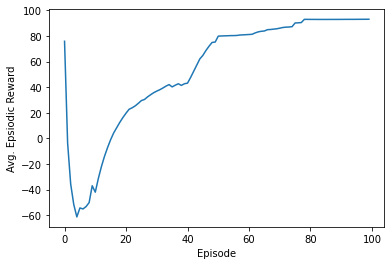

In [11]:
import matplotlib.pyplot as plt

plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()